In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.special import jv, kv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline


In [5]:
# import mc data file
mcfile = 'mc_data/mc_data_rs100_run2.npy'
# mcfile = 'mc_data/testing.npy'
mcdata = np.load(mcfile)
mc_df = pd.DataFrame(mcdata, columns=['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 'num_dsa', 'den_dsa'])


In [9]:
# add relevant columns

mc_df['A_LL'] = mc_df['num_dsa']/mc_df['den_dsa']
mc_df['<cos(phi_kp)>'] = np.cos(mc_df['phi_kp'])*mc_df['A_LL']
mc_df['<cos(phi_Dp)>'] = np.cos(mc_df['phi_Dp'])*mc_df['A_LL']
mc_df['<cos(phi_kp)cos(phi_Dp)>'] = np.cos(mc_df['phi_kp'])*np.cos(mc_df['phi_Dp'])*mc_df['A_LL']
mc_df['<sin(phi_kp)sin(phi_Dp)>'] = np.sin(mc_df['phi_kp'])*np.sin(mc_df['phi_Dp'])*mc_df['A_LL']

mc_df['corr_coeff'] = mc_df['delta']/mc_df['pT']

In [123]:
# function to plot histograms

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 14  
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"

labels = {
    'num_dsa': 'DSA',
         'den_dsa': 'Total',
         'A_LL': r'$A_{LL}$',
         '<cos(phi_kp)>': r'$\langle \cos(\phi_{kp}) \rangle$',
         '<cos(phi_Dp)>': r'$\langle \cos(\phi_{\Delta p}) \rangle$',
         '<cos(phi_kp)cos(phi_Dp)>': r'$\langle \cos(\phi_{kp}) \cos(\phi_{\Delta p}) \rangle$',
         '<sin(phi_kp)sin(phi_Dp)>': r'$\langle \sin(\phi_{kp}) \sin(\phi_{\Delta p}) \rangle$'
         }

def plot_histogram(df, plot_q, weights, constraints={}, **options):

    asp_ratio = 5/3
    psize = 4
    fig, axs = plt.subplots(2, 2, figsize=(asp_ratio*psize, psize), sharex=True, gridspec_kw={'width_ratios': [5, 1], 'height_ratios':[3,1]})

    # make bins
    range = [df[plot_q].min(), df[plot_q].max()]
    nbins = options.get('nbins', 10)
    bin_width = options.get('binwidth', (range[1] - range[0])/nbins)
    bins = options.get('bins', np.arange(np.floor(range[0]/bin_width)*bin_width, np.ceil(range[1]/bin_width)*bin_width, bin_width))

    # enforce constraints
    mask = pd.Series(True, index=df.index)
    for var, (low, high) in constraints.items(): mask &= df[var].between(low, high)
    fixed_df = df[mask]

    if fixed_df.empty:
        print('Error: selected dataframe is empty - constraints are too constraining')
        return

    for iw in weights: assert iw in list(df.columns), f'Error: option for weight {iw} not recognized'
    lumi = options.get('lumi', 10) # total integrated luminosity in fb^-1
    lumi *= options.get('efficiency', 1) # correct for detector efficiency

    colors = ['black', 'red', 'blue', 'green']

    # make plot data         
    for iw, weight in enumerate(weights):
        
        total_counts, plot_bins = np.histogram(fixed_df[plot_q], bins=bins, weights=fixed_df['den_dsa'])
        plot_counts, _ = np.histogram(fixed_df[plot_q], bins=bins, weights=fixed_df[weight])
        bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])

        # ensure bins are properly averaged
        n_entries, _ = np.histogram(fixed_df[plot_q], bins=bins)
        plot_counts = np.array([icount/(bin_width*ientry) if ientry != 0 else 0 for icount, ientry in zip(plot_counts, n_entries)])
        total_counts = np.array([icount/(bin_width*ientry) if ientry != 0 else 0 for icount, ientry in zip(total_counts, n_entries)])
        
        # errors are calculated for a given integrated luminosity (5% systematic error added per 1505.05783)
        if '_dsa' in weight: 
            stat_errors = np.sqrt(total_counts/lumi)
            sys_errors = 0.05*np.abs(plot_counts)
        else:  
            stat_errors = np.array([np.sqrt((1+ic)/(lumi*tc)) if tc != 0 else 0 for ic, tc in zip(plot_counts, total_counts)])
            sys_errors = 0.05*plot_counts
            
        total_errors = np.sqrt((stat_errors**2)+(sys_errors)**2)

        rel_errors = np.array([(np.abs(ie)/ic) if ic != 0 else 0 for ic, ie in zip(plot_counts, total_errors)])

        # make data plot
        axs[0,0].errorbar(
            bin_centers, plot_counts, yerr=total_errors,
            fmt=options.get('fmt', 'o'), 
            capsize=3, elinewidth=0.5, capthick=0.5, color=colors[iw]
        )
        axs[0,0].step(bin_centers, plot_counts, where='mid', linestyle='-', color=colors[iw], label=labels[weight], linewidth=0.5)

        # make relative error plot           
        axs[1,0].step(bin_centers, rel_errors, where='mid', linestyle='--', color=colors[iw], label=labels[weight], linewidth=0.5)
        
    axs[0,0].legend(frameon=False)

    # make info box for constraints
    info_text = fr'Integrated luminosity: ${lumi}\,\, \mathrm{{fb}}^{{-1}}$'+'\n'
    info_text += fr'$\sqrt{{s}} = {round(np.sqrt(df['s'][0]))}\,\, \mathrm{{GeV}}$'+'\n'
    info_text += 'Constraints:\n'
    for var, (low, high) in constraints.items():
        info_text += fr'$ {low} < {var} < {high}$'+'\n'
    axs[0,1].text(
        0.0, 0.0, info_text, 
        ha='left', va='bottom', 
        fontsize=12, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.3)
    )
    axs[0,1].set_axis_off()

    # set plot info
    if options.get('y_limits'): axs[0,0].set_ylim(options.get('y_limits'))
    # if options.get('x_limits'): 
    axs[0,0].set_xlim(options.get('x_limits', [plot_bins[0], plot_bins[-1]]))
    axs[1,0].set_xlim(options.get('x_limits', [plot_bins[0], plot_bins[-1]]))
    
    axs[0,0].set_title(options.get('title', ''))
    axs[0,0].set_ylabel(options.get('y_label', 'Frequency'), loc='top')
    axs[1,0].set_xlabel(options.get('x_label', fr'${plot_q}$'), loc='right')

    axs[1,0].set_ylabel(r'$\delta^{\mathrm{rel.}}(\%)$', loc='bottom')
    
    axs[0,0].set_yscale(options.get('y_scale', 'linear'))
    axs[0,0].set_xscale(options.get('x_scale', 'linear'))

    # axs[1,0].set_ylim([0, 100])
    axs[1,0].set_yscale('log')
    
    axs[0,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
    axs[0,0].grid(options.get('grid', False)) 
    if options.get('zeroline', False): axs[0,0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
    if options.get('saveas'): fig.savefig(options.get('saveas'), dpi=400, bbox_inches="tight")

    # hide last axis
    axs[1, 1].axis('off')

    plt.subplots_adjust(hspace=0.1)


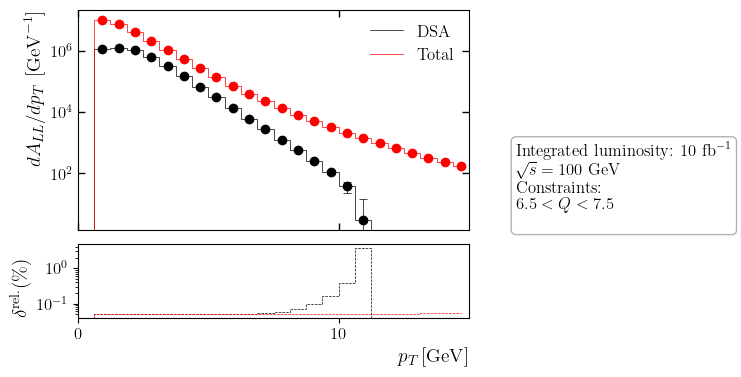

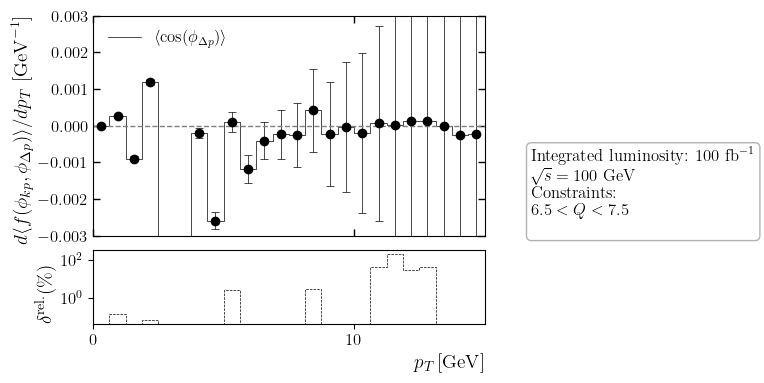

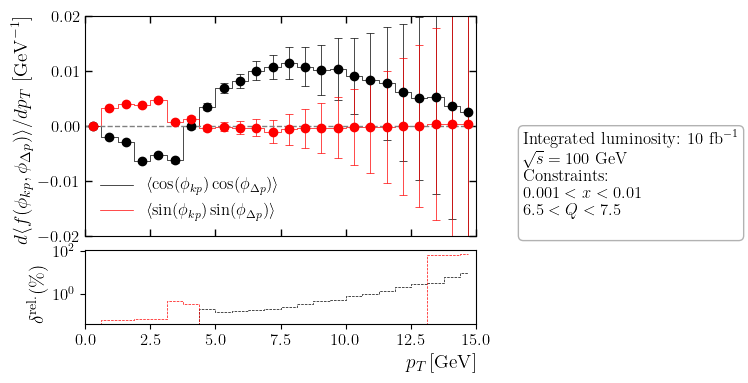

In [131]:
# plot relevant quantities 

Q_bins = [i for i in range(0, 20, 2)]
pT_bins = np.linspace(0, 15.0, num=25)
phi_bins = [i/(2*np.pi) for i in range(15)]

plot_histogram(mc_df, 'pT', ['num_dsa', 'den_dsa'], 
                   {
                    # 'x': [0.0010, 0.01],
                    'Q': [6.5, 7.5]
                   }, 
                   lumi = 10,
                   bins = pT_bins, 
                   y_scale='log', 
                   # x_scale='log',
                   # x_limits = [0, 11], 
                   nbins = 10, 
                   # y_limits = [10,10**9],
                   # zeroline = True,
                   y_label=r'$dA_{LL} /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   # saveas='plots/A_LL_run2.pdf'
              )


plot_histogram(mc_df, 'pT', ['<cos(phi_Dp)>'], 
                   {
                    # 'x': [0.0010, 0.01],
                    'Q': [6.5, 7.5]
                   }, 
                   lumi = 100,
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   # nbins = 10, 
                   bins = pT_bins, 
                   y_limits = [-0.003,0.003],
                   zeroline = True,
                   y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas = 'plots/TT_corr_run2.pdf'
              )

plot_histogram(mc_df, 'pT', ['<cos(phi_kp)cos(phi_Dp)>', '<sin(phi_kp)sin(phi_Dp)>'], 
                   {
                    'x': [0.0010, 0.01],
                    'Q': [6.5, 7.5]
                   }, 
                   lumi = 10,
                   efficiency = 1, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   # nbins = 10, 
                   y_limits = [-0.02,0.02],
                   zeroline = True,
                   y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dp_T \,\,[\mathrm{GeV}^{-1}]$', 
                   x_label=r'$p_T\, [\mathrm{GeV}]$',
                   saveas = 'plots/LT_corr_run2.pdf'
                  )

